# Combine all the predictions, and map uncertainty

Ran 30 predictions, now we need to compute the ensemble median and the interquartile range.

At 1km resolution, this requires a ton of memory. Parellize with dask and the `_percentile.py` script, which is adapted from `odc-algo`

- ~12.5 gb per prediction * 30 = 375 GiB 
- Use hugemem queue

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs
import odc.geo.xr

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _percentile import xr_quantile


In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

## Analysis Parameters

In [4]:
var = 'ER'
suffix='20230320'

In [ ]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions_uncertainty/'+var+'/'
files = os.listdir(base)

In [ ]:
pred_filepaths = [base+i for i in files if i.endswith('.nc')]
len(pred_filepaths)

### Quickly plot the results to inspect

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(15, 5))

i=0
for pred in pred_filepaths:
    print("  {:02}/{:02}\r".format(i + 1, len(range(0, len(pred_filepaths)))), end="")
    ds=xr.open_dataarray(pred, chunks=dict(x=1050, y=680, time=1))
    ds.sum(['x','y']).compute().plot(ax=ax, alpha=0.25, c='lightskyblue')
    i+=1 

# ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+var+'_2003_2021_5km_LGBM_'+suffix+'.nc')
# ds.sum(['x','y']).plot(ax=ax, c='darkblue', label='lgbm w/ all training data')
# plt.axhline(0, c='grey', linestyle='--')
plt.title('Ensembles')
# ax.legend()

## Find median and interquantile range

In [ ]:
arrs=[]
for pred in pred_filepaths:
    ds=xr.open_dataarray(pred, chunks=dict(x=1050, y=680, time=1)) #680, longitude=1050, time=1
    arrs.append(ds.rename(pred[-8:-3]))
    
ds = xr.merge(arrs)
ds = ds.to_array()

In [ ]:
ds = xr_quantile(ds, quantiles=[0.25, 0.50, 0.75], nodata=np.nan)

In [ ]:
ds = ds.rename({'band':var+'_quantiles'}).to_array().squeeze().drop('variable')
ds.attrs['nodata']=np.nan
ds

In [ ]:
%%time
ds = ds.compute()

### Plot the results

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(15, 5))
ds.sel(quantile=0.25).sum(['x','y']).plot(ax=ax, alpha=0.5, c='lightskyblue', label='0.25')
ds.sel(quantile=0.50).sum(['x','y']).plot(ax=ax, alpha=0.5, c='darkgreen', label='median')
ds.sel(quantile=0.75).sum(['x','y']).plot(ax=ax, alpha=0.5, c='lightskyblue', label='0.75')

# da = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+var+'_2003_2021_5km_LGBM_'+suffix+'.nc')
# da.sum(['x','y']).plot(ax=ax, c='darkblue', label='lgbm w/ all training data')
# plt.axhline(0, c='grey', linestyle='--')
ax.legend()
plt.title('Uncertanity modelling, quantiles of ensembles')

## Save to netcdf

Add attritbutes and naming convention ready for upload to zenodo

Need to reproject to 5km for uploading to zenodo as the 1km resolutuion datasets are too large


In [ ]:
name = 'Ecosystem_respiration'
version = 'v1.1'

In [ ]:
ds = ds.rename(name)
ds.attrs['units'] = 'gC/m2/month'
ds

In [ ]:
ds = ds.to_dataset(dim='quantile').rename({0.25:'ER_25th_percentile', 0.5:'ER_median', 0.75:'ER_75th_percentile', 'x':'longitude', 'y':'latitude'})
ds = assign_crs(ds, crs='EPSG:4326')

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_'+var+'_2003_2022_1km_quantiles_'+version+'.nc')


### Reproject to 5km resolution

In [ ]:
from odc.geo.geobox import zoom_out

grid = zoom_out(ds.odc.geobox, 5)

ds_5km = ds.odc.reproject(how=grid, resampling='average')

ds_5km.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_'+var+'_2003_2022_5km_quantiles_'+version+'.nc')

## Map Uncertainty

In [ ]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions_uncertainty/'+var+'/'
files = os.listdir(base)

pred_filepaths = [base+i for i in files if i.endswith('.nc')]

### Convert to PgC/year

In [ ]:
geobox = xr.open_dataarray(pred_filepaths[0]).odc.geobox
grid = geobox.to_crs('EPSG:3577')

In [ ]:
%%time
i=0
arrs=[]
for pred in pred_filepaths:
    print(" {:03}/{:03}\r".format(i+1, len(pred_filepaths)), end="")
    ds=xr.open_dataarray(pred, chunks=dict(x=1100, y=1100, time=1))
    ds = ds.odc.reproject(how=grid,resampling='bilinear').compute()
    area_per_pixel = ds.geobox.resolution[1]**2
    ds = ds * area_per_pixel * 1e-15 * 12
    ds = ds.sel(time=slice('2003','2021')).chunk(dict(x=1100, y=1100)).groupby('time.year').sum().mean('year').compute()
    arrs.append(ds.rename(pred[-8:-3]))
    i+=1

In [ ]:
ds = xr.merge(arrs)
ds = ds.to_array()

### Find the median abosulte deviation and coefficient of variation 

In [ ]:
median = ds.median(dim='variable')
dev = np.abs(ds-median)
mad = dev.median(dim='variable').compute()

In [ ]:
cv = mad/median

In [ ]:
median.attrs['units']='PgC/year'
mad.attrs['nodata']=np.nan
mad = mad.rename('MAD')
mad.attrs['units']='PgC/year'
mad = mad.where(mad>0)

### Save MAD and CV to netcdf

In [ ]:
mad.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/MAD_uncertainty_'+var+'_PgCyear_1km_'+suffix+'.nc')
cv.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/Coef_Var_'+var+'_1km_'+suffix+'.nc')

### Fraction of agreement

In [ ]:
count_of_sinks = xr.where(ds<0, 1, 0)
count_of_sources = xr.where(ds>0, 1, 0)

In [ ]:
count_of_sources = count_of_sources.sum('variable')
count_of_sources = count_of_sources / len(ds.variable)

In [ ]:
count_of_sinks = count_of_sinks.sum('variable')
count_of_sinks = count_of_sinks / len(ds.variable)
# count_of_sinks = count_of_sinks.where(~mask)

In [ ]:
frac_of_agreement = xr.where(median<0, count_of_sinks, count_of_sources)
frac_of_agreement = frac_of_agreement.where(frac_of_agreement>0)

In [ ]:
frac_of_agreement.attrs['nodata']=np.nan
frac_of_agreement = frac_of_agreement.rename('fraction_of_agreement')

In [ ]:
frac_of_agreement.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/uncertainty/Frac_agreement_'+var+'_1km_'+suffix+'.nc')

### Re-open datasets if replotting

In [5]:
var='ER'
suffix='20230320'

In [6]:
frac_of_agreement = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/uncertainty/Frac_agreement_'+var+'_1km_'+suffix+'.nc')
mad = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/uncertainty/MAD_uncertainty_'+var+'_PgCyear_1km_'+suffix+'.nc')
cv = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/uncertainty/Coef_Var_'+var+'_1km_'+suffix+'.nc')

### Plot

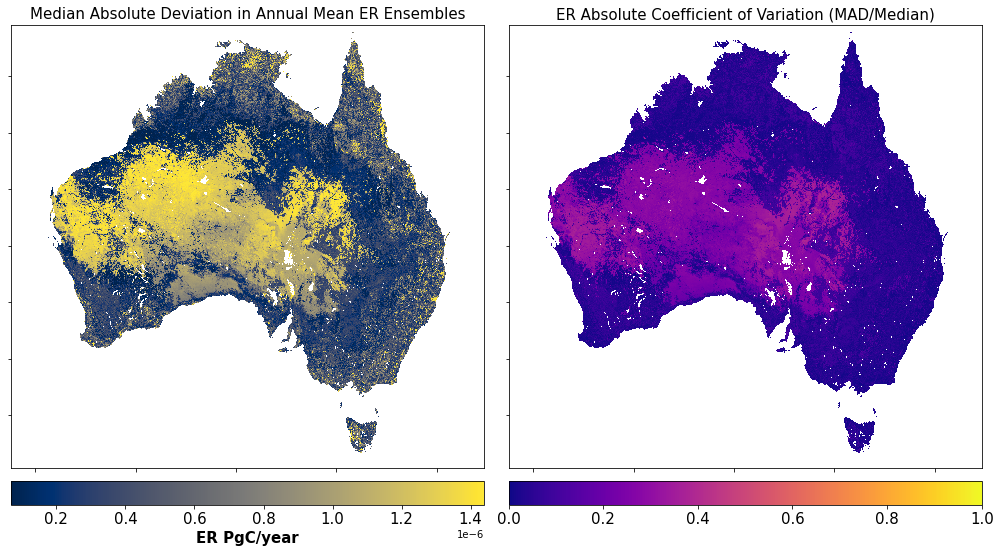

In [9]:
fontsize=15
fig, ax = plt.subplots(1,2, figsize=(14,8), sharey=True, sharex=True)
# im = median.where(median!=0).plot.imshow(ax=ax[0,0], vmax=0.000035, vmin=-0.000035, cmap='RdBu',add_labels=False)

im = mad.plot.imshow(ax=ax[0], robust=True, cmap='cividis', add_labels=False, add_colorbar=False)
cbar = plt.colorbar(im, location='bottom', pad=0.025, ax=ax[0])
cbar.set_label(label=var+' PgC/year', size=15, weight='bold')
cbar.ax.tick_params(labelsize=15)
# cbar.formatter.set_powerlimits((0, 0))

im2 = np.abs(cv).plot.imshow(ax=ax[1],vmax=1, vmin=0, cmap='plasma', add_labels=False, add_colorbar=False)
cbar2 = plt.colorbar(im2, location='bottom', pad=0.025, ax=ax[1])
# cbar2.set_label(label=var+' PgC/year', size=15, weight='bold')
cbar2.ax.tick_params(labelsize=15)

# frac_of_agreement.plot.imshow(ax=ax[1,1], cmap='viridis_r', robust=True, add_labels=False)
# plt.gcf().axes[-2].label.set_fontsize(20)
aa = plt.gcf().axes
# aa[-4].tick_params(labelsize=fontsize) 
# aa[-3].tick_params(labelsize=fontsize) 
aa[-1].tick_params(labelsize=fontsize) 
aa[-2].tick_params(labelsize=fontsize) 
# aa[-4].ticklabel_format(style='sci', scilimits=[-4, 6])
for a in ax.ravel():
    a.set_yticklabels([])
    a.set_xticklabels([])

# ax[0,0].set_title('Median of Annual Mean NEE Ensembles', fontsize=fontsize)
ax[0].set_title('Median Absolute Deviation in Annual Mean '+var+' Ensembles', fontsize=fontsize)
ax[1].set_title(var+' Absolute Coefficient of Variation (MAD/Median)', fontsize=fontsize)
# ax[1,1].set_title("Fraction of Model Ensemble Members where Annual NEE Sign Agrees",  fontsize=fontsize)
plt.tight_layout();
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/Uncertainty_perpixel_'+var+'_'+suffix+'.png', bbox_inches='tight')

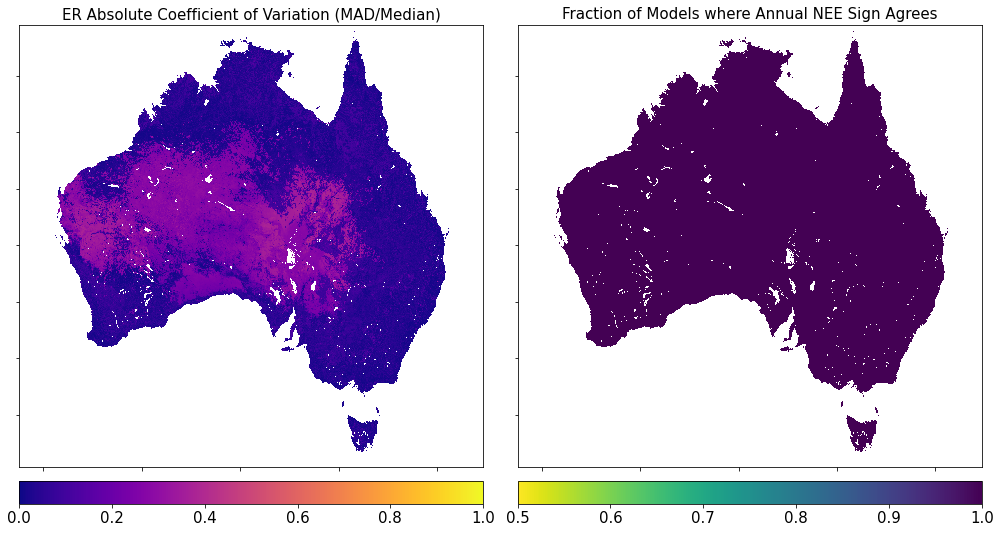

In [8]:
fontsize=15
fig, ax = plt.subplots(1,2, figsize=(14,8), sharey=True, sharex=True)
# im = median.where(median!=0).plot.imshow(ax=ax[0,0], vmax=0.000035, vmin=-0.000035, cmap='RdBu',add_labels=False)

im = np.abs(cv).plot.imshow(ax=ax[0], vmax=1, vmin=0, cmap='plasma', add_labels=False, add_colorbar=False)
cbar = plt.colorbar(im, location='bottom', pad=0.025, ax=ax[0])
cbar.set_label(label=' ', size=15, weight='bold')
cbar.ax.tick_params(labelsize=15)
# cbar.formatter.set_powerlimits((0, 0))

# im2 = np.abs(cv).plot.imshow(ax=ax[1],vmax=1, vmin=0, cmap='plasma', add_labels=False, add_colorbar=False)
im2 = frac_of_agreement.plot.imshow(ax=ax[1],vmax=1, vmin=0.5, cmap='viridis_r', add_labels=False, add_colorbar=False)
cbar2 = plt.colorbar(im2, location='bottom', pad=0.025, ax=ax[1])
# cbar2.set_label(label=var+' PgC/year', size=15, weight='bold')
cbar2.ax.tick_params(labelsize=15)

# frac_of_agreement.plot.imshow(ax=ax[1,1], cmap='viridis_r', robust=True, add_labels=False)
# plt.gcf().axes[-2].label.set_fontsize(20)
aa = plt.gcf().axes
# aa[-4].tick_params(labelsize=fontsize) 
# aa[-3].tick_params(labelsize=fontsize) 
aa[-1].tick_params(labelsize=fontsize) 
aa[-2].tick_params(labelsize=fontsize) 
# aa[-4].ticklabel_format(style='sci', scilimits=[-4, 6])
for a in ax.ravel():
    a.set_yticklabels([])
    a.set_xticklabels([])

# ax[0,0].set_title('Median of Annual Mean NEE Ensembles', fontsize=fontsize)
ax[1].set_title('Fraction of Models where Annual NEE Sign Agrees', fontsize=fontsize)
ax[0].set_title(var+' Absolute Coefficient of Variation (MAD/Median)', fontsize=fontsize)
# ax[1,1].set_title("Fraction of Model Ensemble Members where Annual NEE Sign Agrees",  fontsize=fontsize)
plt.tight_layout();
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/Uncertainty_perpixel_frac_of_agreement'+var+'_'+suffix+'.png', bbox_inches='tight')